<h3>Calculating the semantic distance</h3>

<p>
    This notebook attempts to answer the second Basic question: Calculate semantic distance between diseases within the biobank using node counts. Which are the two closest, which are the two most distant? Which symptoms are common, which are unique?
</p>
<p>
    The steps are:
    <ul style="list-style-type:circle">
      <li>linking the biobank with mappings of diseases and symptoms and genes</li>
      <li>loading HPO ontology graph with symptoms</li>
      <li>finding corresponding HPO symptoms for the diseases in the biobank</li>
      <li>measuring the pairwise semantic distance in HPO between two symptoms (finding the shortest path in graph theory) and distance between two diseases(I'm not sure about this part.)</li>
    </ul>
</p>

In [1]:
import pandas as pd
import numpy as np

from owlready2 import *
from rdflib import query
from rdflib.plugins.sparql import prepareQuery
from rdflib import URIRef

import networkx as nx

import pylab as py
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the biobank and the disease attribute
biobank = pd.read_csv('data/sample_catalogue_rd_connect.csv')
biobank.head(3)

,Disease,MaterialType,MaterialTypeDetailed,AnatomicalSite,Sex,DiagnosisType,Genotype,AgeAtSampling,Affected,Family,RelatedSamples,Registry,BiobankID,RegistryID
0,urn:miriam:ncit:C46951,SERUM,http://purl.obolibrary.org/obo/FMA_63083,http://purl.obolibrary.org/obo/UBERON_0000178,http://purl.obolibrary.org/obo/PATO_0000384,CLINICAL,FALSE,15.0,TRUE,UNK,NAV,UNK,87919,NaN
1,urn:miriam:ncit:C46951,SERUM,http://purl.obolibrary.org/obo/FMA_63083,http://purl.obolibrary.org/obo/UBERON_0000178,http://purl.obolibrary.org/obo/PATO_0000384,CLINICAL,FALSE,20.0,TRUE,UNK,NAV,UNK,87919,NaN
2,urn:miriam:orphanet:Orphanet_101075,OTHER,http://purl.obolibrary.org/obo/FMA_63877,http://purl.obolibrary.org/obo/UBERON_0002097,http://purl.obolibrary.org/obo/PATO_0000384,MOLECULAR,TRUE,26.0,TRUE,UNK,UNK,UNK,87919,NaN


In [3]:
# load the diseases attribute
disease_rd = pd.read_csv('data/rdconnect_Disease_2017-10-04_02-59-41.csv')
disease_rd.head(3)

,IRI,PreferredTerm,Description,Code
0,http://www.orpha.net/ORDO/Orphanet_1440,Ring chromosome 14,Ring chromosome 14,1440
1,http://identifiers.org/ncit/C49651,Healthy Subject,An individual who is or becomes a participant ...,C49651
2,urn:miriam:orphanet:Orphanet_802,Multiple sclerose,NaN,802


In [4]:
# load the mapping between diseases and phentypes/symptoms and corresponding HPO-id
# The first step is to extract all column names from the txt file. 
# It is because I did not find a suitable parser to read the entire file including the header.
column_names = pd.read_csv('data/ALL_SOURCES_ALL_FREQUENCIES_diseases_to_genes_to_phenotypes.txt',
                    sep=('<tab>'), engine='python')
names_list = [str(item) for item in column_names.columns]
names_list[0] = names_list[0].split(': ')[1] # The first item was '#Format: diseaseId' before this step.
mappings_disease_symptom = pd.read_csv('data/ALL_SOURCES_ALL_FREQUENCIES_diseases_to_genes_to_phenotypes.txt',
                                        sep=('\t'), names=names_list, skiprows=1)
print(mappings_disease_symptom.head())

     diseaseId gene-symbol  gene-id(entrez)      HPO-ID  \
0  OMIM:600142       HTRA1             5654  HP:0000007   
1  OMIM:600142       HTRA1             5654  HP:0001251   
2  OMIM:600142       HTRA1             5654  HP:0002448   
3  OMIM:600142       HTRA1             5654  HP:0003419   
4  OMIM:600142       HTRA1             5654  HP:0007204   

                        HPO-term-name  
0     Autosomal recessive inheritance  
1                              Ataxia  
2          Progressive encephalopathy  
3                       Low back pain  
4  Diffuse white matter abnormalities  


In [5]:
# create a new column storing the diseaseCode in the mappings_disease_symptom dataframe
def extract_code(diseaseID):
    '''
    get diseaseCode out from diseaseId
    '''
    diseaseCode = str(diseaseID).split(':')[1]
    return diseaseCode
mappings_disease_symptom['diseaseCode'] = mappings_disease_symptom.diseaseId
mappings_disease_symptom.diseaseCode = mappings_disease_symptom.diseaseCode.apply(extract_code)
mappings_disease_symptom[['diseaseId','diseaseCode']].head(3)

,diseaseId,diseaseCode
0,OMIM:600142,600142
1,OMIM:600142,600142
2,OMIM:600142,600142


In [6]:
# create a new column storing diseaseCode in the biobank dataframe
def mapping_disease_biobank_diseaserd(diseaseName):
    '''
    map the disease names in the biobank to the diseaseCode stored in the disease_rn dataframe
    '''
    return disease_rd.Code[disease_rd.IRI == diseaseName].values[0]
biobank['diseaseCode'] = biobank.Disease
biobank['diseaseCode'] = biobank.diseaseCode.apply(mapping_disease_biobank_diseaserd)
biobank[['Disease','diseaseCode']].head(3)

,Disease,diseaseCode
0,urn:miriam:ncit:C46951,46951
1,urn:miriam:ncit:C46951,46951
2,urn:miriam:orphanet:Orphanet_101075,101075


In [7]:
# find the corresponding symptomsHPO_IDs for all diseaseCodes in biobank,
# and store it in d dictionary, keys indicating the diseaseCode
# values indicating the corresponding symptoms
disease_with_symptoms = {}
# all the disease in the biobank with their Ids and codes
# diseaseCode is unique for Disease, therefore I here use 'max()' will not influence the diseaseCode
disease_bank = biobank[['Disease','diseaseCode']].groupby('Disease').max() 
# disease_bank.head() # show the disease_bank
disease_names = disease_bank.index.values # all diseaseIds in the biobank
disease_codes = disease_bank.diseaseCode.values # all diseaseCodes in the biobank
# map diseaseCode with Symptoms
for i in range(len(disease_names)):
    if disease_names[i] not in disease_with_symptoms:
        disease_with_symptoms[disease_names[i]] = \
        mappings_disease_symptom['HPO-ID'][disease_codes[i]==
                                           mappings_disease_symptom.diseaseCode].values
# show the disease with one example of its corresonding symptoms (HPO-ID)
# if no corresponding symptoms were found, show 'None'
for key, value in disease_with_symptoms.items():
    if len(value) > 0:
        print(key,value[0])
    else:
        print(key,'None')

urn:miriam:orphanet:Orphanet_378 None
urn:miriam:orphanet:Orphanet_35656 None
urn:miriam:orphanet:Orphanet_90289 None
urn:miriam:orphanet:Orphanet_83330 None
urn:miriam:orphanet:Orphanet_86812 None
urn:miriam:orphanet:Orphanet_53540 None
urn:miriam:orphanet:Orphanet_599 None
urn:miriam:orphanet:Orphanet_62 None
urn:miriam:orphanet:Orphanet_209185 None
urn:miriam:orphanet:Orphanet_265 None
urn:miriam:orphanet:Orphanet_206966 None
urn:miriam:orphanet:Orphanet_270 HP:0000298
urn:miriam:orphanet:Orphanet_101082 None
urn:miriam:orphanet:Orphanet_606 HP:0000518
urn:miriam:orphanet:Orphanet_269 HP:0000407
urn:miriam:orphanet:Orphanet_166 None
urn:miriam:orphanet:Orphanet_45448 None
urn:miriam:orphanet:Orphanet_284232 None
urn:miriam:orphanet:Orphanet_34515 None
urn:miriam:orphanet:Orphanet_83418 None
urn:miriam:orphanet:Orphanet_261 None
urn:miriam:orphanet:Orphanet_267 None
urn:miriam:ncit:C46951 None
urn:miriam:orphanet:Orphanet_268 None
urn:miriam:orphanet:Orphanet_1460 None
urn:miriam:orp

In [8]:
# select the diseases with symptoms and corresponding HPO-IDs 
# only select those diseases with less than 100 symtoms for computational concern afterwards
disease_has_lessthan100_symptoms = {}
for key,value in disease_with_symptoms.items():
    if len(value) is not 0 and len(value) < 100:
        disease_has_lessthan100_symptoms[key] = value
        
for key, value in disease_has_lessthan100_symptoms.items():
    print(key,len(value))

diseaseids_has_lessthan100_symptoms = list(disease_has_lessthan100_symptoms.keys())

urn:miriam:orphanet:Orphanet_2609 24
urn:miriam:orphanet:Orphanet_258 44
urn:miriam:orphanet:Orphanet_270 9
urn:miriam:orphanet:Orphanet_565 53
urn:miriam:orphanet:Orphanet_606 2
urn:miriam:orphanet:Orphanet_269 30
urn:miriam:orphanet:Orphanet_1239 16
urn:miriam:orphanet:Orphanet_16 12
urn:miriam:orphanet:Orphanet_157846 20
urn:miriam:orphanet:Orphanet_3463 72
urn:miriam:orphanet:Orphanet_98895 15
urn:miriam:orphanet:Orphanet_610 20
urn:miriam:orphanet:Orphanet_602 48
urn:miriam:orphanet:Orphanet_273 23
urn:miriam:orphanet:Orphanet_101075 16
urn:miriam:orphanet:Orphanet_597 4
urn:miriam:orphanet:Orphanet_95 32
urn:miriam:orphanet:Orphanet_2020 42


In [9]:
# load the HPO ontology
owlURL = "http://purl.obolibrary.org/obo/hp.owl"
# owlURL = "file:///home/shuang/projects/ontology_test/data/hp.owl"
onto = get_ontology(owlURL)
onto.load()

# create rdf graph
my_world = World()
my_world.get_ontology(owlURL).load()
graph = my_world.as_rdflib_graph()

In [10]:
# create networkx graph with HPO info
# the edges are named by part of the URI, for example: 'HP_010048'
nx_graph = nx.Graph()
for a,b in graph.query('''SELECT ?a ?b 
                           WHERE {
                              ?a <http://www.w3.org/2000/01/rdf-schema#subClassOf> ?b .
                              }
                            '''):
    node1 = str(a).split('/')[-1]
    node2 = str(b).split('/')[-1]
    nx_graph.add_edge(node1,node2)

['GO_0016788', 'HP_0012239', 'GO_0046611']


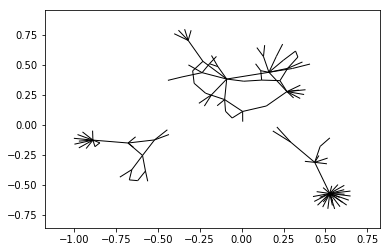

In [16]:
# show a subgraph of the entire nx_graph
base = list(nx_graph._node.keys())[:3]
print(base)
depth = 3
foundset = {
    key for source in base for key in nx.single_source_shortest_path(nx_graph,source,
                                                                    cutoff=depth).keys()
}
nx_subgraph = nx_graph.subgraph(foundset)
nx.draw_networkx_edges(nx_subgraph,pos=nx.spring_layout(nx_subgraph),with_label=True)
plt.draw()
py.savefig('subgraph.png')

<h3>Toy examples</h3>
<p>
    The following two sections show two toy examples:
    <ul style="list-style-type:circle">
      <li>Shortest path from one symptom to another symptom.</li>
      <li>The distances between every pair of two symptoms in two diseases as a weighted graph</li>
    </ul>
</p>

In [17]:
# toy example1: 
print("The shortes path between node 'HP_0100148' and 'HP_0000011' is : \n",nx.shortest_path(nx_graph,'HP_0100148', 'HP_0000011'))

The shortes path between node 'HP_0100148' and 'HP_0000011' is : 
 ['HP_0100148', 'HP_0100057', 'HP_0010164', 'HP_0010160', 'HP_0001780', 'HP_0001760', 'HP_0001886', 'HP_0002754', 'HP_0012649', 'HP_0100577', 'HP_0025487', 'HP_0000014', 'HP_0000009', 'HP_0000011']


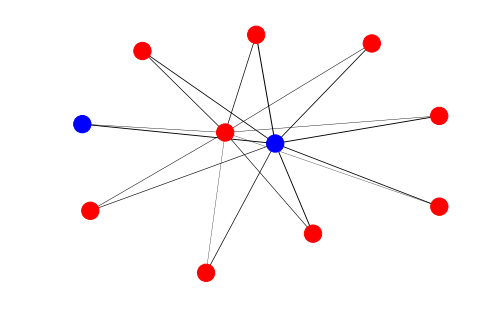

In [26]:
# toy exmaple2:
example_graph = nx.Graph()
disease1 = diseaseids_has_lessthan100_symptoms[4]
disease2 = diseaseids_has_lessthan100_symptoms[2]
symptoms1 = disease_has_lessthan100_symptoms[disease1]
symptoms2 = disease_has_lessthan100_symptoms[disease2]
for symptom1 in symptoms1:
    for symptom2 in symptoms2:
        symptom1 = symptom1.replace(':','_')
        symptom2 = symptom2.replace(':','_')
        weight = len(nx.shortest_path(nx_graph,symptom1, symptom2)) - 2
#         print(symptom1,symptom2,weight)
        example_graph.add_edge(symptom1,symptom2,weight=weight)
# specify node color
color_map = []
for node in example_graph:
#     print(node)
    if node.replace('_',':') in symptoms1:
        color_map.append('blue')
    else:
        color_map.append('red')
# visualiza the graph
edgewidth = [ d['weight']*0.1 for (u,v,d) in example_graph.edges(data=True)]
pos=nx.spring_layout(example_graph)
nx.draw(example_graph,pos=pos, nodelist=pos.keys(), node_color=color_map, width=edgewidth, with_label=True)

In [27]:
# calculate the pairwise distance for diseases
# by averaging the pairwise distance in symptoms from the two diseases
def pairwise_distance_diseases(disease1_id, disease2_id):
    '''
    Calculate the average distance among all pairwise distances of two symptoms of two diseases
    Input: disease1_id str, disease2_id str
           the diseaseId, for example, 'urn:miriam:orphanet:Orphanet_101075'
    Output: distance float
            the average number of nodes between two symptoms from the two diseases
    '''
    symptoms1 = disease_has_lessthan100_symptoms[disease1_id]
    symptoms2 = disease_has_lessthan100_symptoms[disease2_id]
    distance = 0
    # sum up all pairwise distances between teo symptoms from the two diseases
    # the parwise distance between two symptoms is represented by the shortest path in the graph
    # which is the number of nodes between the two symptoms in this case
    for node1 in symptoms1:
        for node2 in symptoms2:
            node1_iri = node1.replace(':','_')
            node2_iri = node2.replace(':','_')
            distance += len(nx.shortest_path(nx_graph,node1_iri, node2_iri))-1
#     print(float(distance), len(symptoms1), len(symptoms2))
    return float(distance)/(len(symptoms1)*len(symptoms2))

In [28]:
# method1: representing the distance between two diseases as 
# the average pairwise distance between any two symptoms for the two diseases
disease_number = len(disease_has_lessthan100_symptoms.keys())
disease_pairwise_distance1 = np.zeros((disease_number,disease_number),np.int8) # an array for storing the distances
for i in range(len(diseaseids_has_lessthan100_symptoms)):
    for j in range(len(diseaseids_has_lessthan100_symptoms)):
        disease_pairwise_distance1[i][j] = pairwise_distance_diseases(diseaseids_has_lessthan100_symptoms[i],
                                                                    diseaseids_has_lessthan100_symptoms[j])
print(disease_pairwise_distance1)

[[0 5 5 5 5 5 6 6 5 6 4 5 5 5 6 4 6 5]
 [5 7 7 7 8 7 7 8 7 7 7 7 7 7 7 7 8 7]
 [5 7 6 7 7 6 7 7 7 7 6 6 7 7 7 6 8 6]
 [5 7 7 7 8 7 7 8 7 7 7 7 7 7 7 7 8 7]
 [5 8 7 8 4 7 7 7 7 8 7 7 7 7 8 7 8 7]
 [5 7 6 7 7 6 7 7 7 7 6 7 7 7 7 6 8 6]
 [6 7 7 7 7 7 5 6 6 7 7 8 8 7 7 7 7 7]
 [6 8 7 8 7 7 6 5 7 7 7 8 8 8 8 8 8 8]
 [5 7 7 7 7 7 6 7 5 7 6 7 7 7 6 7 6 6]
 [6 7 7 7 8 7 7 7 7 7 7 7 8 7 7 7 7 7]
 [4 7 6 7 7 6 7 7 6 7 5 6 6 7 7 6 7 6]
 [5 7 6 7 7 7 8 8 7 7 6 5 6 7 7 6 8 6]
 [5 7 7 7 7 7 8 8 7 8 6 6 6 7 7 6 8 7]
 [5 7 7 7 7 7 7 8 7 7 7 7 7 7 8 7 8 7]
 [6 7 7 7 8 7 7 8 6 7 7 7 7 8 7 8 7 7]
 [4 7 6 7 7 6 7 8 7 7 6 6 6 7 8 3 8 6]
 [6 8 8 8 8 8 7 8 6 7 7 8 8 8 7 8 7 7]
 [5 7 6 7 7 6 7 8 6 7 6 6 7 7 7 6 7 5]]


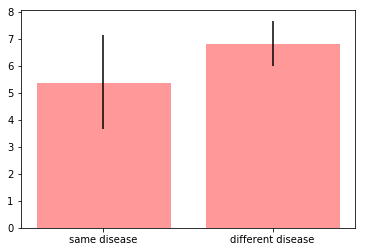

In [36]:
distance_same_diseases = []
distance_diff_diseases = []
for i in range(disease_pairwise_distance1.shape[0]):
    for j in range(i,disease_pairwise_distance1.shape[1]):
        if i == j:
            distance_same_diseases.append(disease_pairwise_distance1[i][j])
        else:
            distance_diff_diseases.append(disease_pairwise_distance1[i][j])
means = [np.mean(np.array(distance_same_diseases)),np.mean(np.array(distance_diff_diseases))]
errors = [np.std(np.array(distance_same_diseases)),np.std(np.array(distance_diff_diseases))]
plt.bar([1,2],height=means, yerr=errors, facecolor='#ff9999', edgecolor='white')
plt.xticks([1,2],['same disease','different disease'])
plt.show()

In [37]:
# method2: representing the distance between two diseases as 
# (sum of pairwise distances between symptoms from the two dseases)
# divideded by adding (sum of pairwse distances between symptoms within disease1)
# with (sum of pairwse distances between symptoms within disease2)
disease_pairwise_distance2 = np.zeros((disease_number,disease_number),np.float32) # an array for storing the distances
for i in range(len(diseaseids_has_lessthan100_symptoms)):
    for j in range(len(diseaseids_has_lessthan100_symptoms)):
        disease1_disease2 = pairwise_distance_diseases(diseaseids_has_lessthan100_symptoms[i],
                                                                    diseaseids_has_lessthan100_symptoms[j])
        within_disease1 = pairwise_distance_diseases(diseaseids_has_lessthan100_symptoms[i],
                                                     diseaseids_has_lessthan100_symptoms[i])
        within_disease2 = pairwise_distance_diseases(diseaseids_has_lessthan100_symptoms[j],
                                                     diseaseids_has_lessthan100_symptoms[j])
        disease_pairwise_distance2[i][j] = float(disease1_disease2)/float(((within_disease1)+(within_disease2)+1))
np.set_printoptions(precision=1)
print(disease_pairwise_distance2)

[[ 0.   0.7  0.7  0.7  1.   0.7  0.9  1.1  0.9  0.7  0.7  0.8  0.7  0.7
   0.8  0.9  0.8  0.8]
 [ 0.7  0.5  0.5  0.5  0.6  0.5  0.5  0.6  0.5  0.5  0.5  0.6  0.5  0.5
   0.5  0.6  0.5  0.5]
 [ 0.7  0.5  0.5  0.5  0.7  0.5  0.6  0.6  0.6  0.5  0.5  0.6  0.5  0.5
   0.5  0.6  0.5  0.5]
 [ 0.7  0.5  0.5  0.5  0.6  0.5  0.6  0.6  0.5  0.5  0.5  0.6  0.5  0.5
   0.5  0.6  0.5  0.5]
 [ 1.   0.6  0.7  0.6  0.4  0.6  0.7  0.7  0.7  0.6  0.6  0.7  0.6  0.6
   0.7  0.8  0.7  0.7]
 [ 0.7  0.5  0.5  0.5  0.6  0.5  0.6  0.6  0.6  0.5  0.5  0.6  0.5  0.5
   0.5  0.6  0.5  0.5]
 [ 0.9  0.5  0.6  0.6  0.7  0.6  0.5  0.6  0.5  0.5  0.6  0.7  0.6  0.5
   0.5  0.7  0.5  0.6]
 [ 1.1  0.6  0.6  0.6  0.7  0.6  0.6  0.5  0.6  0.6  0.7  0.8  0.7  0.6
   0.6  0.9  0.6  0.7]
 [ 0.9  0.5  0.6  0.5  0.7  0.6  0.5  0.6  0.5  0.5  0.5  0.7  0.6  0.5
   0.5  0.7  0.5  0.6]
 [ 0.7  0.5  0.5  0.5  0.6  0.5  0.5  0.6  0.5  0.5  0.5  0.6  0.5  0.5
   0.5  0.6  0.5  0.5]
 [ 0.7  0.5  0.5  0.5  0.6  0.5  0.6  0.7  0.5  0.

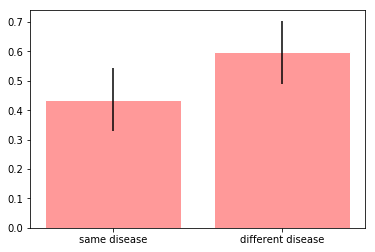

In [38]:
distance_same_diseases2 = []
distance_diff_diseases2 = []
for i in range(disease_pairwise_distance2.shape[0]):
    for j in range(i,disease_pairwise_distance2.shape[1]):
        if i == j:
            distance_same_diseases2.append(disease_pairwise_distance2[i][j])
        else:
            distance_diff_diseases2.append(disease_pairwise_distance2[i][j])
means2 = [np.mean(np.array(distance_same_diseases2)),np.mean(np.array(distance_diff_diseases2))]
errors2 = [np.std(np.array(distance_same_diseases2)),np.std(np.array(distance_diff_diseases2))]
plt.bar([1,2],height=means2, yerr=errors2, facecolor='#ff9999', edgecolor='white')
plt.xticks([1,2],['same disease','different disease'])
plt.show()

In [39]:
# most shared symptoms in the mappings_disease_symptom dataframe
grouped_mappings = mappings_disease_symptom.groupby('HPO-ID').count()
grouped_mappings.sort_values('diseaseCode',ascending=False)[['diseaseId']]

,diseaseId
HPO-ID,
HP:0000007,2391
HP:0000006,1861
HP:0001249,1322
HP:0001250,1289
HP:0001263,1164
HP:0004322,1146
HP:0001252,1019
HP:0000252,796
HP:0000639,783


In [40]:
# most shared symptoms in the biobank
symptoms_disease_mappings_in_biobank = {}
for key, values in disease_has_lessthan100_symptoms.items():
    for value in values:
        if value in symptoms_disease_mappings_in_biobank:
            symptoms_disease_mappings_in_biobank[value].append(key)
        else:
            symptoms_disease_mappings_in_biobank[value] = [key]
disease_counts = []
for key, value in symptoms_disease_mappings_in_biobank.items():
    if len(value) >= 2:
        disease_counts.append([key,len(value)])
#     print(key,len(value))

In [41]:
# Third most common symptoms in the biobank
print('The most common symptoms, together with its occurance in the biobank are: \n',sorted(disease_counts,key=lambda x:x[1], reverse=True)[:3])

The most common symptoms, together with its occurance in the biobank are: 
 [['HP:0008316', 24], ['HP:0003198', 15], ['HP:0002650', 10]]


In [42]:
# The disease with most of the symptoms in the biobank
mappings_disease_symptom.groupby('diseaseId').count().diseaseCode.argmax()
# bug with the files?

'ORPHA:791'